# Merged model evaluation

In [1]:
import sys
sys.path.append("..")
import ProbabilisticParcellation.evaluate as ev
import ProbabilisticParcellation.util as ut
import ProbabilisticParcellation.functional_profiles as fp
import Functional_Fusion.dataset as ds
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from scipy import stats
import glob
import numpy as np
import re



/Users/callithrix/Documents/Projects/Functional_Fusion/code/env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
files = sorted(
    glob.glob(f'{ut.model_dir}//Models/Evaluation/nettekoven_68/eval_on-task*space*'))
files.extend(sorted(
    glob.glob(f'{ut.model_dir}//Models/Evaluation/nettekoven_68/eval_on-rest*space*')))

list_of_dfs = []
for f, file in enumerate(files):
    t = pd.read_csv(file, delimiter='\t')
    list_of_dfs.append(t)
    t['source'] = file.split('/')[-1].strip('.tsv')

D = pd.concat(list_of_dfs, ignore_index=True).reset_index(drop=True)
D.drop_duplicates(subset=D.columns.difference(['source']))

D.shape

(8092, 15)

In [3]:
figsize = (10, 10)

crits = ['dcbc_group','dcbc_indiv']

# recover info
for r,row in D.iterrows():
    print(r, row.source)
    new = fp.recover_info(row, info_type='evaluation_info')
    # print(r, new.train_data)
    D.iloc[r] = new
                    

figsize = (10,10)
# Determine origin of model: clustered_in_C3 (and then refitted to C2), clustered (on C2 or C3 data, but not refitted to another space), data (pure data-driven model)
for r,row in D.iterrows():
    if row['atlas'] == 'MNISymC2':
        if 'fromC3' in row['source']:
            D.loc[r,'origin'] = 'clustered_in_C3'
        elif 'mixed' in row['source']:
            D.loc[r,'origin'] = 'clustered'
        else:
            D.loc[r,'origin'] = 'data'
    elif row['atlas'] == 'MNISymC3':
        if 'mixed' in row['source']:
            D.loc[r,'origin'] = 'clustered'
        else:
            D.loc[r,'origin'] = 'data'

# Determine whether model was trained on rest, task and rest, or task only
for r,row in D.iterrows():
    if ['HCP'] == row['train_data']:
        D.loc[r, 'trained_on'] = 'rest'
    elif 'HCP' in row['train_data']:
        D.loc[r, 'trained_on'] = 'task_and_rest'
    else:
        D.loc[r, 'trained_on'] = 'task'
        

# Determine whether model was tested on rest, task and rest, or task only
for r, row in D.iterrows():
    if 'HCP' == row['test_data']:
        D.loc[r, 'tested_on'] = 'rest'
    else:
        D.loc[r, 'tested_on'] = 'task'

# Leave-one-out / All / Individual indicator
for r, row in D.iterrows():
    n_train_datasets = len(row['train_data'])
    if n_train_datasets==1:
        D['train_type'] = 'indiv'
    elif n_train_datasets==6:
        D['train_type'] = 'loo'
    elif n_train_datasets==7:
        if 'HCP' in row['train_data']:
            D['train_type'] = 'loo'
        else:
            D['train_type'] = 'all'
    elif n_train_datasets==8:
        D['train_type'] = 'all'

# Symmetric / Asymmetric indicator
for r, row in D.iterrows():
    if 'sym' in row['source']:  
        D.loc[r, 'symmetry'] = 'symmetric'
    else:
        D.loc[r, 'symmetry'] = 'asymmetric'


# Cross-validation indicator
for r, row in D.iterrows():
    train_test_match = [data in row.test_data for data in row.train_data]
    if np.any(train_test_match):
        D.loc[r, 'cv'] = False
    else:
        D.loc[r, 'cv'] = True

D.tail()


0 eval_on-task_sym_Hc_space-MNISymC3_K-10
1 eval_on-task_sym_Hc_space-MNISymC3_K-10
2 eval_on-task_sym_Hc_space-MNISymC3_K-10
3 eval_on-task_sym_Hc_space-MNISymC3_K-10
4 eval_on-task_sym_Hc_space-MNISymC3_K-10
5 eval_on-task_sym_Hc_space-MNISymC3_K-10
6 eval_on-task_sym_Hc_space-MNISymC3_K-10
7 eval_on-task_sym_Hc_space-MNISymC3_K-10
8 eval_on-task_sym_Hc_space-MNISymC3_K-10
9 eval_on-task_sym_Hc_space-MNISymC3_K-10
10 eval_on-task_sym_Hc_space-MNISymC3_K-10
11 eval_on-task_sym_Hc_space-MNISymC3_K-10
12 eval_on-task_sym_Hc_space-MNISymC3_K-10
13 eval_on-task_sym_Hc_space-MNISymC3_K-10
14 eval_on-task_sym_Hc_space-MNISymC3_K-10
15 eval_on-task_sym_Hc_space-MNISymC3_K-10
16 eval_on-task_sym_Hc_space-MNISymC3_K-10
17 eval_on-task_sym_Hc_space-MNISymC3_K-10
18 eval_on-task_sym_Hc_space-MNISymC3_K-10
19 eval_on-task_sym_Hc_space-MNISymC3_K-10
20 eval_on-task_sym_Hc_space-MNISymC3_K-10
21 eval_on-task_sym_Hc_space-MNISymC3_K-10
22 eval_on-task_sym_Hc_space-MNISymC3_K-10
23 eval_on-task_sym_H

,model_name,atlas,K,train_data,train_loglik,subj_num,common_kappa,dcbc_group,dcbc_indiv,model_type,...,indivtrain_ind,indivtrain_val,test_data,source,origin,trained_on,tested_on,train_type,symmetry,cv
8087,sym_MdPoNiIbWmDeSoHc,MNISymC3,68,"[MDTB, Pontine, Nishimoto, IBC, WMFS, Demand, ...",151033136.0,95,True,0.080491,0.178135,Models_03,...,half,2,HCP,eval_on-rest_sym_MdPoNiIbWmDeSoHc_space-MNISym...,data,task_and_rest,rest,all,symmetric,False
8088,sym_MdPoNiIbWmDeSoHc,MNISymC3,68,"[MDTB, Pontine, Nishimoto, IBC, WMFS, Demand, ...",151033136.0,96,True,0.080422,0.187654,Models_03,...,half,2,HCP,eval_on-rest_sym_MdPoNiIbWmDeSoHc_space-MNISym...,data,task_and_rest,rest,all,symmetric,False
8089,sym_MdPoNiIbWmDeSoHc,MNISymC3,68,"[MDTB, Pontine, Nishimoto, IBC, WMFS, Demand, ...",151033136.0,97,True,0.073452,0.194412,Models_03,...,half,2,HCP,eval_on-rest_sym_MdPoNiIbWmDeSoHc_space-MNISym...,data,task_and_rest,rest,all,symmetric,False
8090,sym_MdPoNiIbWmDeSoHc,MNISymC3,68,"[MDTB, Pontine, Nishimoto, IBC, WMFS, Demand, ...",151033136.0,98,True,0.142613,0.300651,Models_03,...,half,2,HCP,eval_on-rest_sym_MdPoNiIbWmDeSoHc_space-MNISym...,data,task_and_rest,rest,all,symmetric,False
8091,sym_MdPoNiIbWmDeSoHc,MNISymC3,68,"[MDTB, Pontine, Nishimoto, IBC, WMFS, Demand, ...",151033136.0,99,True,0.106691,0.256460,Models_03,...,half,2,HCP,eval_on-rest_sym_MdPoNiIbWmDeSoHc_space-MNISym...,data,task_and_rest,rest,all,symmetric,False


In [12]:
D[(D.train_type=='loo') & (D.cv == False)]

,model_name,atlas,K,train_data,train_loglik,subj_num,common_kappa,dcbc_group,dcbc_indiv,model_type,...,indivtrain_ind,indivtrain_val,test_data,source,origin,trained_on,tested_on,train_type,symmetry,cv


In [13]:

np.any(D.train_type=='loo')
# D[(D.tested_on=='task') & (D.trained_on=='task')]

False

### Comparing pure task-trained, rest-and-task-trained, and rest-trained parcellations

/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_42367/3752955090.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  D[D.cv==True].groupby(['atlas','origin', 'trained_on', 'K']).mean()


train_loglik   subj_num  common_kappa  \
atlas    origin trained_on    K                                           
MNISymC3 data   rest          10  1.237616e+08  10.801802           1.0   
                              20  1.267122e+08  10.801802           1.0   
                              32  1.283649e+08  10.801802           1.0   
                              34  1.285610e+08  10.801802           1.0   
                              40  1.290849e+08  10.801802           1.0   
                              68  1.305074e+08  10.801802           1.0   
                task          10  1.618215e+07  10.801802           1.0   
                              20  1.684899e+07  11.368932           1.0   
                              34  1.763498e+07  10.801802           1.0   
                              40  1.781318e+07  10.801802           1.0   
                              68  1.841345e+07  10.801802           1.0   
                task_and_rest 10  1.398899e+08  10.801802           1.0   
                              20  1.436830e+08  10.801802           1.0   
                              34  1.461622e+08  10.801802           1.0   
                              40  1.468522e+08  10.801802           1.0   
                              68  1.488512e+08  10.801802           1.0   

                                  dcbc_group  dcbc_indiv  indivtrain_val  
atlas    origin trained_on    K                                           
MNISymC3 data   rest          10    0.096260    0.122273             1.5  
                              20    0.087596    0.170079             1.5  
                              32    0.098028    0.182462             1.5  
                              34    0.100316    0.181911             1.5  
                              40    0.091794    0.179383             1.5  
                              68    0.098571    0.185343             1.5  
                task          10    0.076113    0.126742             1.5  
                              20    0.091555    0.165617             1.5  
                              34    0.078599    0.171876             1.5  
                              40    0.085183    0.173965             1.5  
                              68    0.086250    0.187621             1.5  
                task_and_rest 10    0.102754    0.132501             1.5  
                              20    0.092638    0.160373             1.5  
                              34    0.104862    0.171338             1.5  
                              40    0.100822    0.179936             1.5  
                              68    0.107196    0.190029             1.5

<Figure size 1000x1000 with 0 Axes>

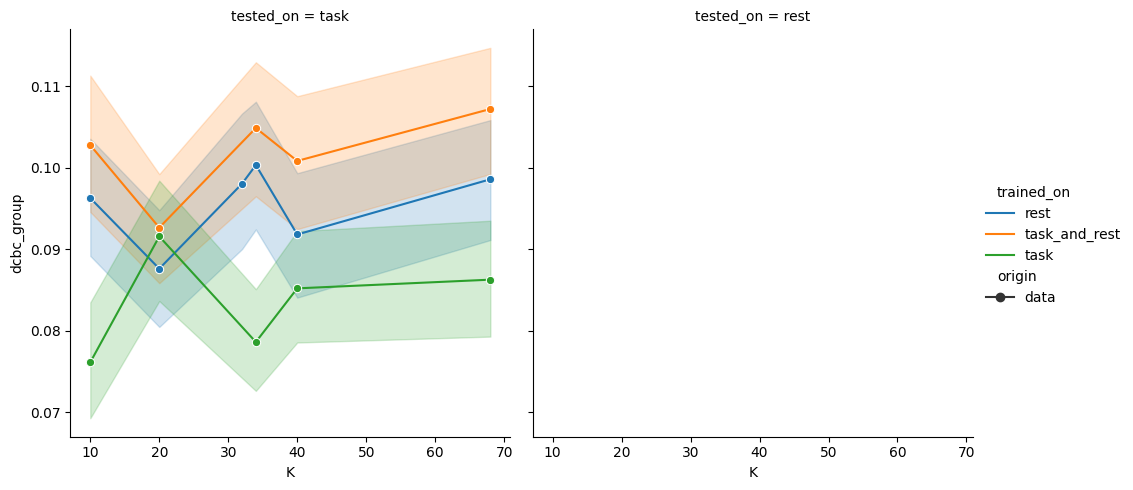

<Figure size 1000x1000 with 0 Axes>

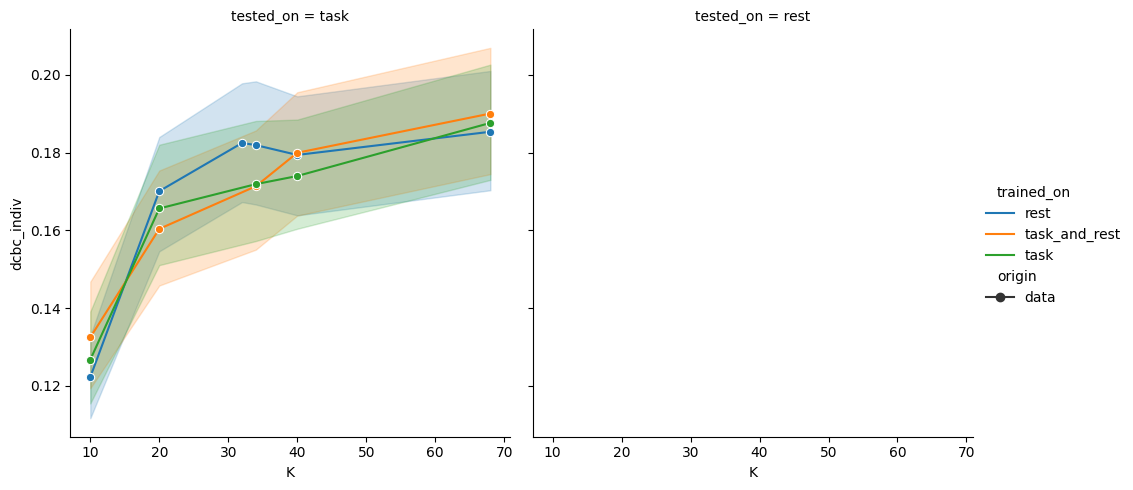

In [14]:

plt.figure(figsize=figsize)
sb.relplot(
    data=D[D.cv==True], x="K", y="dcbc_group", col="tested_on", hue="trained_on", kind="line", col_order=['task', 'rest'], style="origin", markers=True)

plt.figure(figsize=figsize)
sb.relplot(
    data=D[D.cv == True], x="K", y="dcbc_indiv", col="tested_on", hue="trained_on", kind="line", col_order=['task', 'rest'], style="origin", markers=True)

D[D.cv==True].groupby(['atlas','origin', 'trained_on', 'K']).mean()





<Figure size 1000x1000 with 0 Axes>

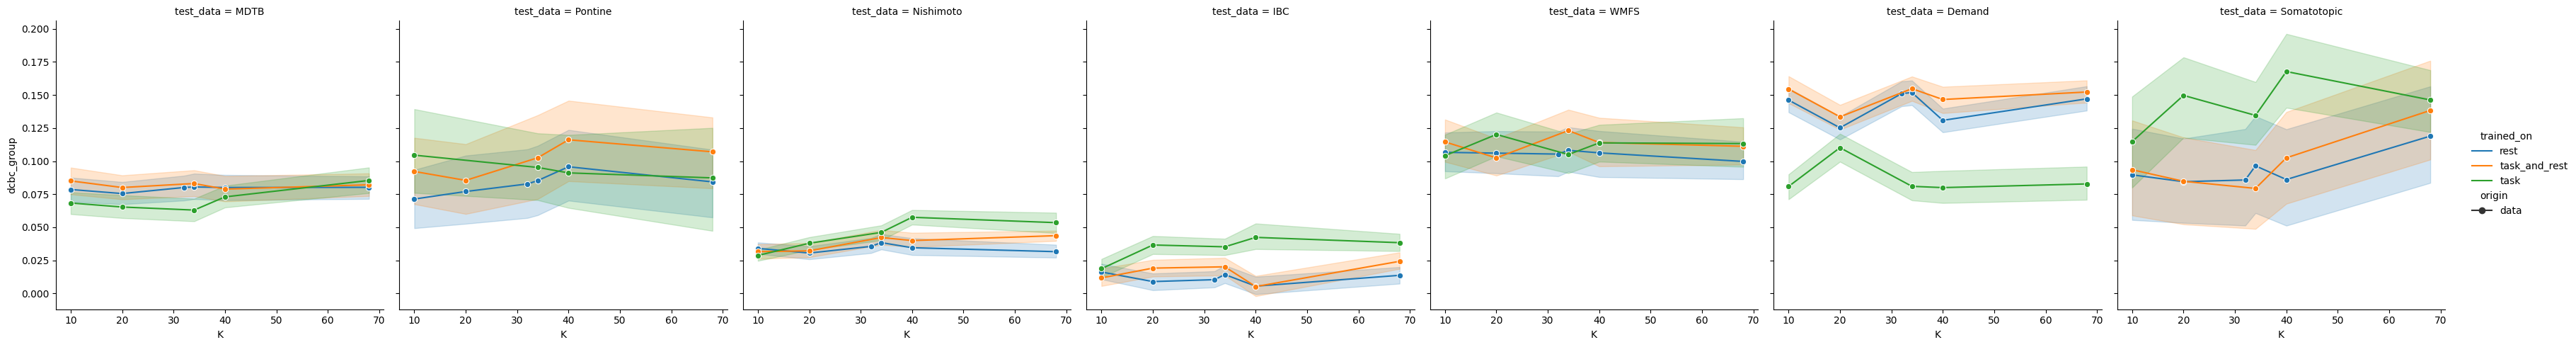

<Figure size 1000x1000 with 0 Axes>

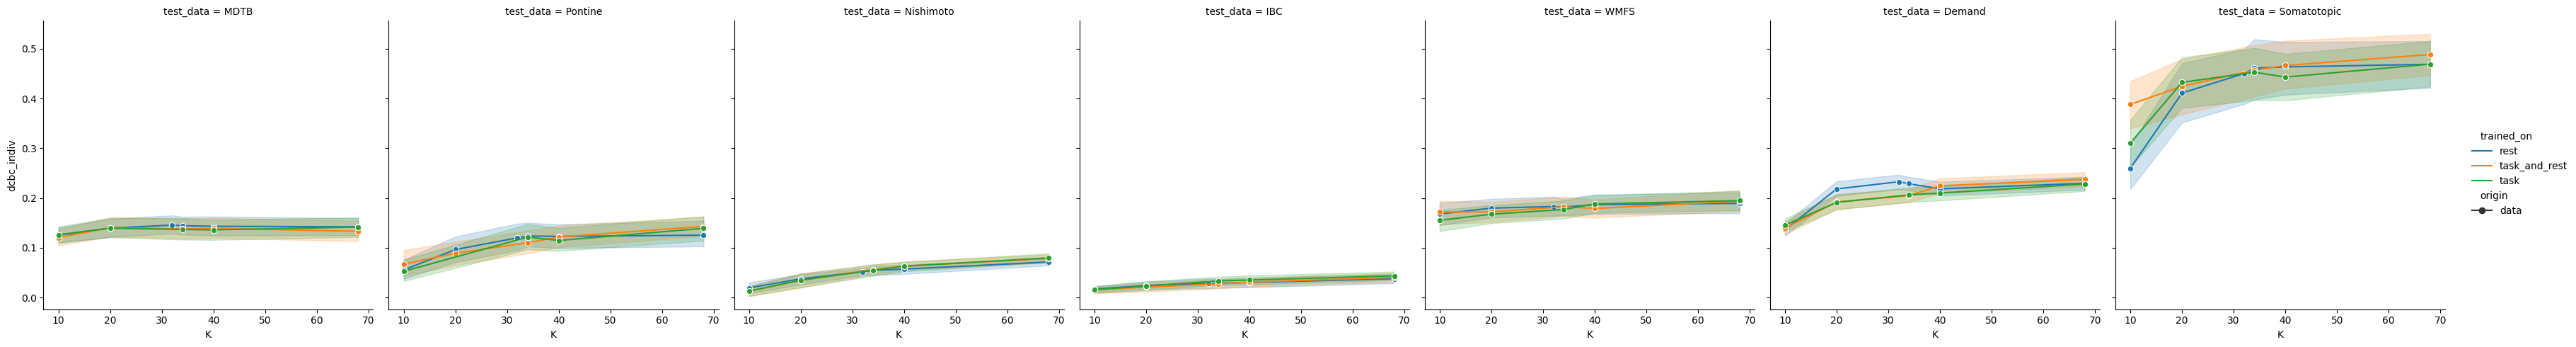

In [15]:

plt.figure(figsize=figsize)
f = sb.relplot(
    data=D[D.cv == True], x="K", y="dcbc_group", col="test_data", hue="trained_on", kind="line", style="origin", markers=True)

plt.figure(figsize=figsize)
f = sb.relplot(
    data=D[D.cv == True], x="K", y="dcbc_indiv", col="test_data", hue="trained_on", kind="line", style="origin", markers=True)
# f.set(ylim=(0, 0.4))


In [16]:
D[(D.cv==True) & (D.tested_on=='task')].tail()

,model_name,atlas,K,train_data,train_loglik,subj_num,common_kappa,dcbc_group,dcbc_indiv,model_type,...,indivtrain_ind,indivtrain_val,test_data,source,origin,trained_on,tested_on,train_type,symmetry,cv
6687,sym_PoNiIbWmDeSo,MNISymC3,68,"[Pontine, Nishimoto, IBC, WMFS, Demand, Somato...",14593062.0,19,True,0.086474,0.166727,Models_03,...,half,2,MDTB,eval_on-task_sym_PoNiIbWmDeSo_space-MNISymC3_K-68,data,task,task,all,symmetric,True
6688,sym_PoNiIbWmDeSo,MNISymC3,68,"[Pontine, Nishimoto, IBC, WMFS, Demand, Somato...",14593062.0,20,True,0.090322,0.140934,Models_03,...,half,2,MDTB,eval_on-task_sym_PoNiIbWmDeSo_space-MNISymC3_K-68,data,task,task,all,symmetric,True
6689,sym_PoNiIbWmDeSo,MNISymC3,68,"[Pontine, Nishimoto, IBC, WMFS, Demand, Somato...",14593062.0,21,True,0.068447,0.096636,Models_03,...,half,2,MDTB,eval_on-task_sym_PoNiIbWmDeSo_space-MNISymC3_K-68,data,task,task,all,symmetric,True
6690,sym_PoNiIbWmDeSo,MNISymC3,68,"[Pontine, Nishimoto, IBC, WMFS, Demand, Somato...",14593062.0,22,True,0.022585,0.136564,Models_03,...,half,2,MDTB,eval_on-task_sym_PoNiIbWmDeSo_space-MNISymC3_K-68,data,task,task,all,symmetric,True
6691,sym_PoNiIbWmDeSo,MNISymC3,68,"[Pontine, Nishimoto, IBC, WMFS, Demand, Somato...",14593062.0,23,True,0.085314,0.137191,Models_03,...,half,2,MDTB,eval_on-task_sym_PoNiIbWmDeSo_space-MNISymC3_K-68,data,task,task,all,symmetric,True


/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_42367/108613435.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Davg = D[D.cv == True].groupby(
/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_42367/108613435.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Davg[Davg.cv == True].groupby(['atlas', 'origin', 'trained_on', 'K']).mean()


cv  train_loglik  subj_num  common_kappa  \
atlas    origin trained_on    K                                               
MNISymC3 data   rest          10  1.0  1.237616e+08  7.428571           1.0   
                              20  1.0  1.267122e+08  7.428571           1.0   
                              32  1.0  1.283649e+08  7.428571           1.0   
                              34  1.0  1.285610e+08  7.428571           1.0   
                              40  1.0  1.290849e+08  7.428571           1.0   
                              68  1.0  1.305074e+08  7.428571           1.0   
                task          10  1.0  1.544242e+07  7.428571           1.0   
                              20  1.0  1.579381e+07  8.083333           1.0   
                              34  1.0  1.689009e+07  7.428571           1.0   
                              40  1.0  1.706712e+07  7.428571           1.0   
                              68  1.0  1.766719e+07  7.428571           1.0   
                task_and_rest 10  1.0  1.391484e+08  7.428571           1.0   
                              20  1.0  1.429405e+08  7.428571           1.0   
                              34  1.0  1.454159e+08  7.428571           1.0   
                              40  1.0  1.461034e+08  7.428571           1.0   
                              68  1.0  1.481041e+08  7.428571           1.0   

                                  dcbc_group  dcbc_indiv  indivtrain_val  
atlas    origin trained_on    K                                           
MNISymC3 data   rest          10    0.077504    0.111570             1.5  
                              20    0.072527    0.158133             1.5  
                              32    0.078696    0.173204             1.5  
                              34    0.082122    0.174769             1.5  
                              40    0.076996    0.174669             1.5  
                              68    0.082210    0.180669             1.5  
                task          10    0.074283    0.117002             1.5  
                              20    0.086643    0.164831             1.5  
                              34    0.080009    0.169031             1.5  
                              40    0.089352    0.170034             1.5  
                              68    0.086690    0.185196             1.5  
                task_and_rest 10    0.083292    0.130760             1.5  
                              20    0.076778    0.153408             1.5  
                              34    0.086456    0.168061             1.5  
                              40    0.086174    0.175057             1.5  
                              68    0.094119    0.187841             1.5

<Figure size 1000x1000 with 0 Axes>

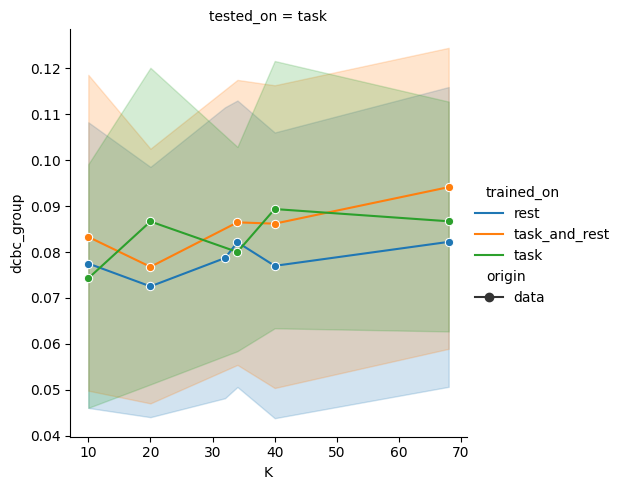

<Figure size 1000x1000 with 0 Axes>

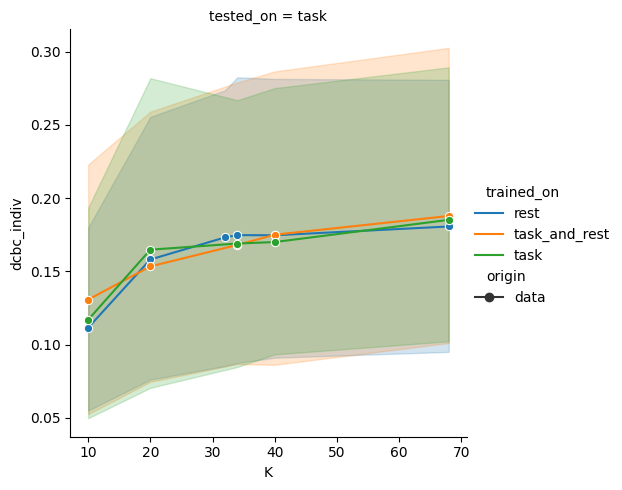

<Figure size 1000x1000 with 0 Axes>

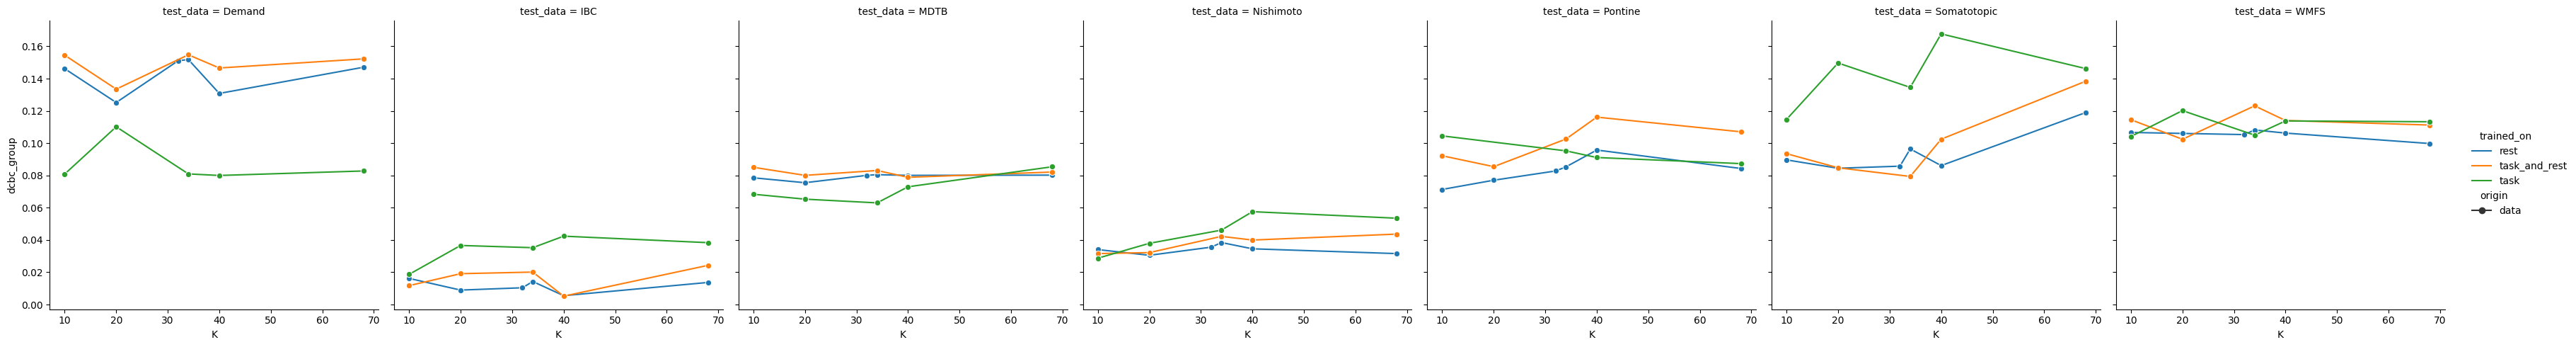

<Figure size 1000x1000 with 0 Axes>

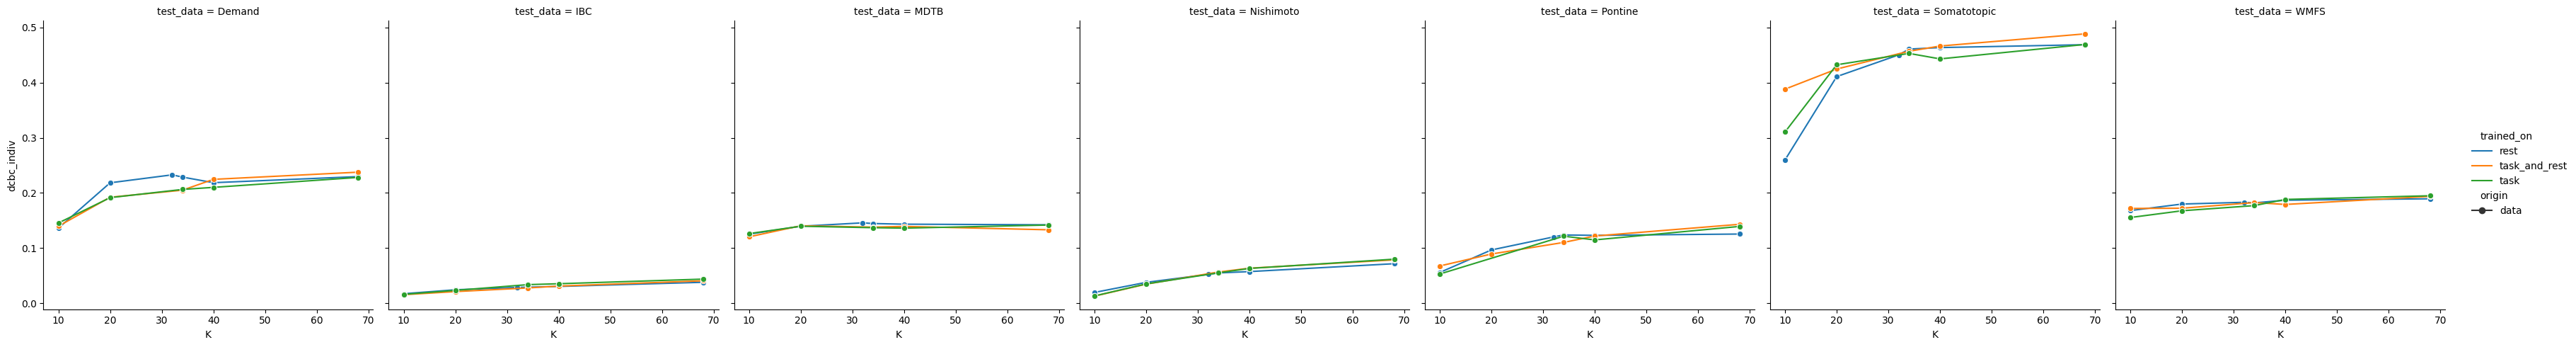

In [28]:
Davg = D[D.cv == True].groupby(
    ['atlas', 'origin', 'model_name', 'K', 'test_data', 'cv', 'trained_on', 'tested_on']).mean().reset_index()
Davg


plt.figure(figsize=figsize)
sb.relplot(
    data=Davg[Davg.cv == True], x="K", y="dcbc_group", col="tested_on", hue="trained_on", kind="line", hue_order=['rest', 'task_and_rest', 'task'], style="origin", markers=True)

plt.figure(figsize=figsize)
sb.relplot(
    data=Davg[Davg.cv == True], x="K", y="dcbc_indiv", col="tested_on", hue="trained_on", kind="line", hue_order=['rest', 'task_and_rest', 'task'], style="origin", markers=True)

plt.figure(figsize=figsize)
sb.relplot(
    data=Davg[Davg.cv == True], x="K", y="dcbc_group", col="test_data", hue="trained_on", kind="line", hue_order=['rest', 'task_and_rest', 'task'], style="origin", markers=True)

plt.figure(figsize=figsize)
sb.relplot(
    data=Davg[Davg.cv == True], x="K", y="dcbc_indiv", col="test_data", hue="trained_on", kind="line", hue_order=['rest', 'task_and_rest', 'task'], style="origin", markers=True)

Davg[Davg.cv == True].groupby(['atlas', 'origin', 'trained_on', 'K']).mean()


In [26]:
ex = pd.read_csv(
    f'{ut.model_dir}/Models/Evaluation/nettekoven_68/eval_on-task+rest_existing.tsv', sep='\t')

# Determine origin of model: clustered_in_C3 (and then refitted to C2), clustered (on C2 or C3 data, but not refitted to another space), data (pure data-driven model)
for r, row in ex.iterrows():
    model_parts = row.model_name.split('_')
    space = row.model_name.split('space-')[1].strip('_')
    train_data = row.model_name.split('_space')[0]
    ex.loc[r, 'atlas'] = space
    ex.loc[r, 'train_data'] = train_data

# Determine whether model was trained on rest, task and rest, or task only
for r, row in ex.iterrows():

    if 'atl-Anatom' == row['train_data']:
        ex.loc[r, 'trained_on'] = 'anatomy'
    elif row['train_data'] in ['atl-Buckner7', 'atl-Buckner17', 'atl-Ji10']:
        ex.loc[r, 'trained_on'] = row['train_data']
    elif 'MDTB10' in row['train_data']:
        ex.loc[r, 'trained_on'] = 'MDTB10'
    elif 'asym_Md' == row['model_name']:
        ex.loc[r, 'trained_on'] = 'asym_Md'
    else:
        ex.loc[r, 'trained_on'] = 'task'


# Determine whether model was tested on rest, task and rest, or task only
for r, row in ex.iterrows():
    if 'HCP' == row['test_data']:
        ex.loc[r, 'tested_on'] = 'rest'
    else:
        ex.loc[r, 'tested_on'] = 'task'

ex['dcbc_group'] = ex['dcbc']

ex.head()


,fit_type,model_name,test_data,subj_num,dcbc,atlas,train_data,trained_on,tested_on,dcbc_group
0,Models_03,asym_Md_space-MNISymC3_K-10,MDTB,0,0.098281,MNISymC3_K-10,asym_Md,task,task,0.098281
1,Models_03,asym_Md_space-MNISymC3_K-10,MDTB,1,0.095214,MNISymC3_K-10,asym_Md,task,task,0.095214
2,Models_03,asym_Md_space-MNISymC3_K-10,MDTB,2,0.049849,MNISymC3_K-10,asym_Md,task,task,0.049849
3,Models_03,asym_Md_space-MNISymC3_K-10,MDTB,3,0.213206,MNISymC3_K-10,asym_Md,task,task,0.213206
4,Models_03,asym_Md_space-MNISymC3_K-10,MDTB,4,0.090611,MNISymC3_K-10,asym_Md,task,task,0.090611


In [33]:
D.K

0       10
1       10
2       10
3       10
4       10
        ..
8087    68
8088    68
8089    68
8090    68
8091    68
Name: K, Length: 8092, dtype: int64

In [27]:
columns_to_keep = ['model_name', 'atlas', 'trained_on', 'tested_on', 'dcbc_group', 'train_data', 'test_data']
result = pd.concat([D[columns_to_keep], ex[columns_to_keep]])

# Make train_data list entries into strings
for r, row in result.iterrows():
    if type(row.train_data) == list:
        result.loc[r, 'train_data'] = '_'.join(row.train_data)


In [28]:
result.head()


,model_name,atlas,trained_on,tested_on,dcbc_group,train_data,test_data
0,sym_Hc,MNISymC3,rest,task,0.058628,HCP,MDTB
1,sym_Hc,MNISymC3,rest,task,0.040882,HCP,MDTB
2,sym_Hc,MNISymC3,rest,task,0.010466,HCP,MDTB
3,sym_Hc,MNISymC3,rest,task,0.144154,HCP,MDTB
4,sym_Hc,MNISymC3,rest,task,0.120750,HCP,MDTB


In [29]:
result.tail()
# result.train_data.unique()



,model_name,atlas,trained_on,tested_on,dcbc_group,train_data,test_data
1261,atl-Ji10_space-MNI152NLin2009cSymC_dseg,MNI152NLin2009cSymC_dseg,atl-Ji10,rest,0.131517,HCP,HCP
1262,atl-Ji10_space-MNI152NLin2009cSymC_dseg,MNI152NLin2009cSymC_dseg,atl-Ji10,rest,0.147609,HCP,HCP
1263,atl-Ji10_space-MNI152NLin2009cSymC_dseg,MNI152NLin2009cSymC_dseg,atl-Ji10,rest,0.128097,HCP,HCP
1264,atl-Ji10_space-MNI152NLin2009cSymC_dseg,MNI152NLin2009cSymC_dseg,atl-Ji10,rest,0.208120,HCP,HCP
1265,atl-Ji10_space-MNI152NLin2009cSymC_dseg,MNI152NLin2009cSymC_dseg,atl-Ji10,rest,0.150397,HCP,HCP


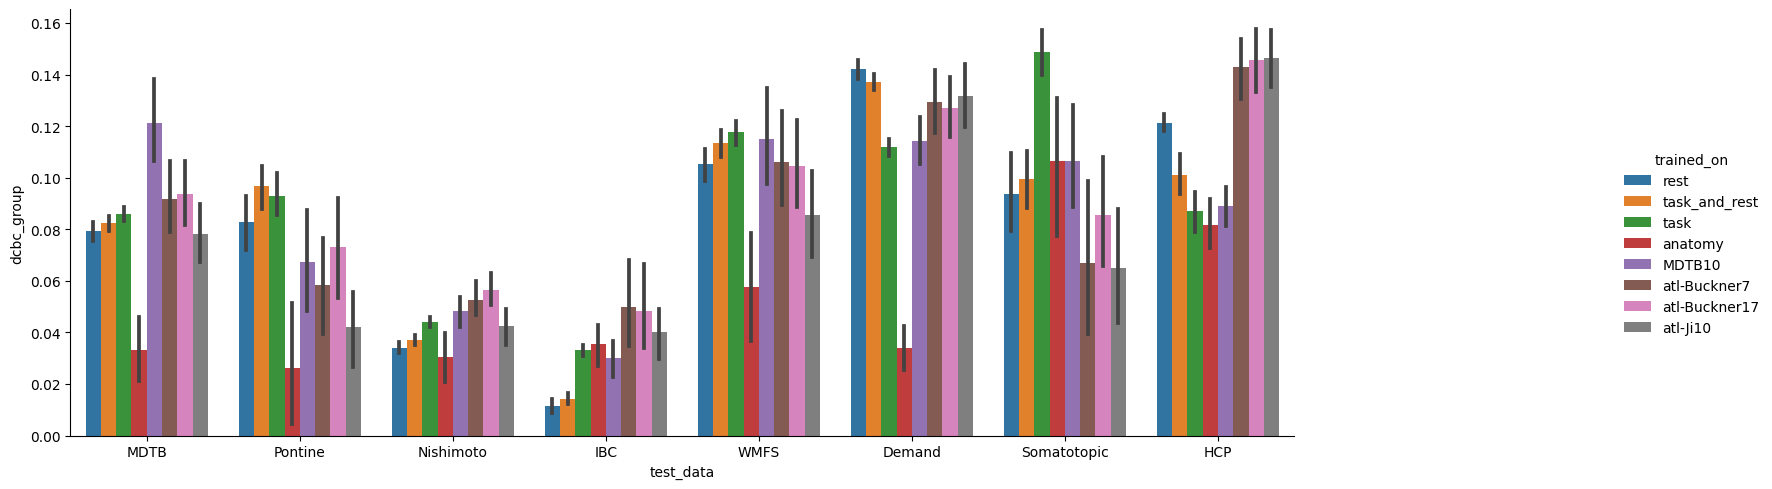

In [30]:

f = sb.catplot(
    data=result, y="dcbc_group", x="test_data", hue="trained_on", kind="bar")

f.fig.set_figwidth(20)


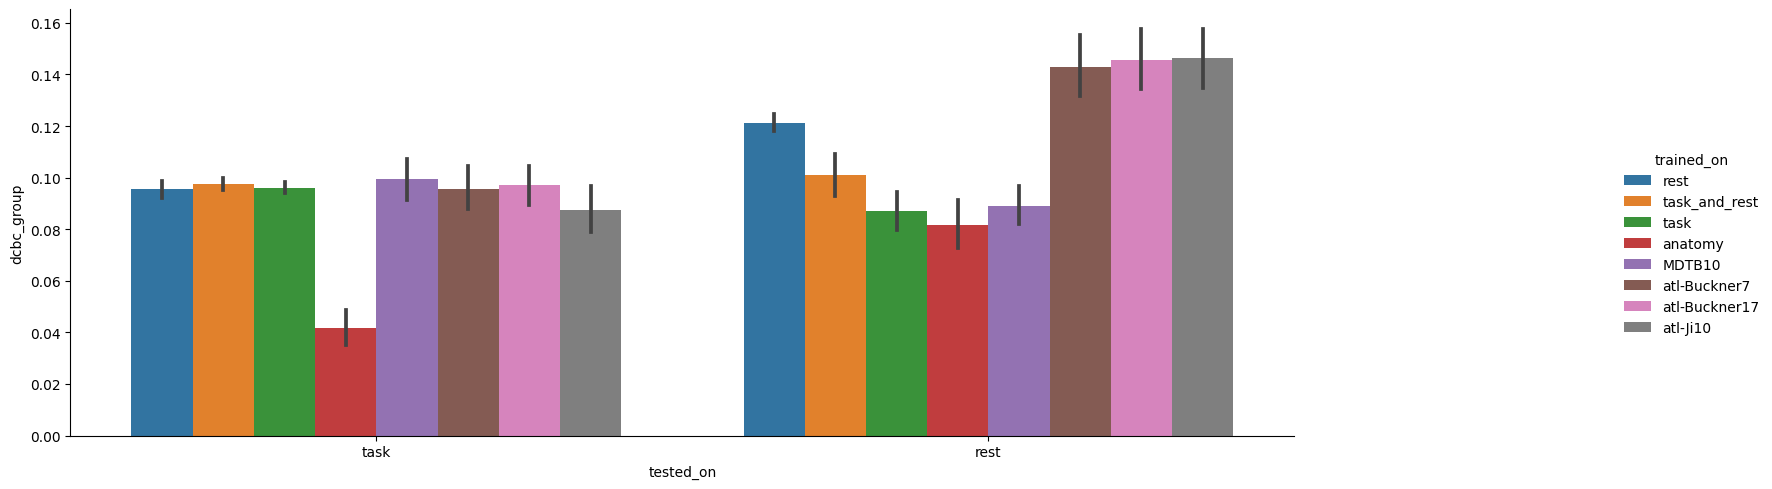

In [32]:

f = sb.catplot(
    data=result, y="dcbc_group", x="tested_on", hue="trained_on", kind="bar")

f.fig.set_figwidth(20)


/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_89717/1251526221.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ex.groupby(['train_data', 'tested_on']).mean()


<Figure size 1000x1000 with 0 Axes>

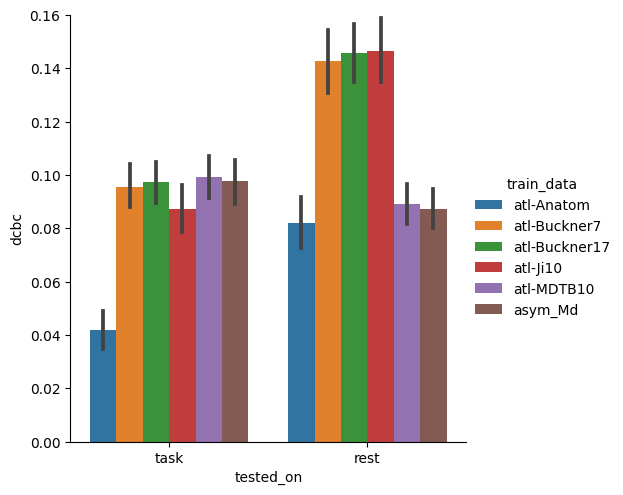

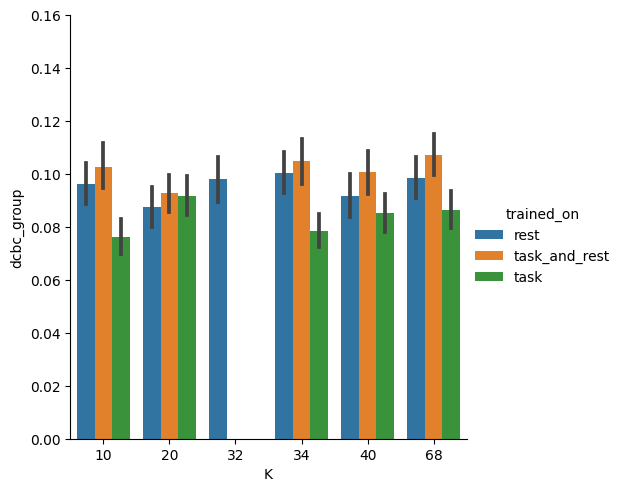

In [31]:

plt.figure(figsize=figsize)


g = sb.catplot(
    data=ex, x="tested_on", y="dcbc", hue="train_data", kind="bar", hue_order=['atl-Anatom', 'atl-Buckner7', 'atl-Buckner17', 'atl-Ji10', 'atl-MDTB10', 'asym_Md'])

ex.groupby(['train_data', 'tested_on']).mean()
g.set(ylim=(0, 0.16))


K=68
g = sb.catplot(
    data=D[(D.cv == True) ], x="K", y="dcbc_group", hue="trained_on", kind="bar")

g.set(ylim=(0, 0.16))


/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_89717/4209954235.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ex.groupby(['train_data', 'tested_on']).mean()


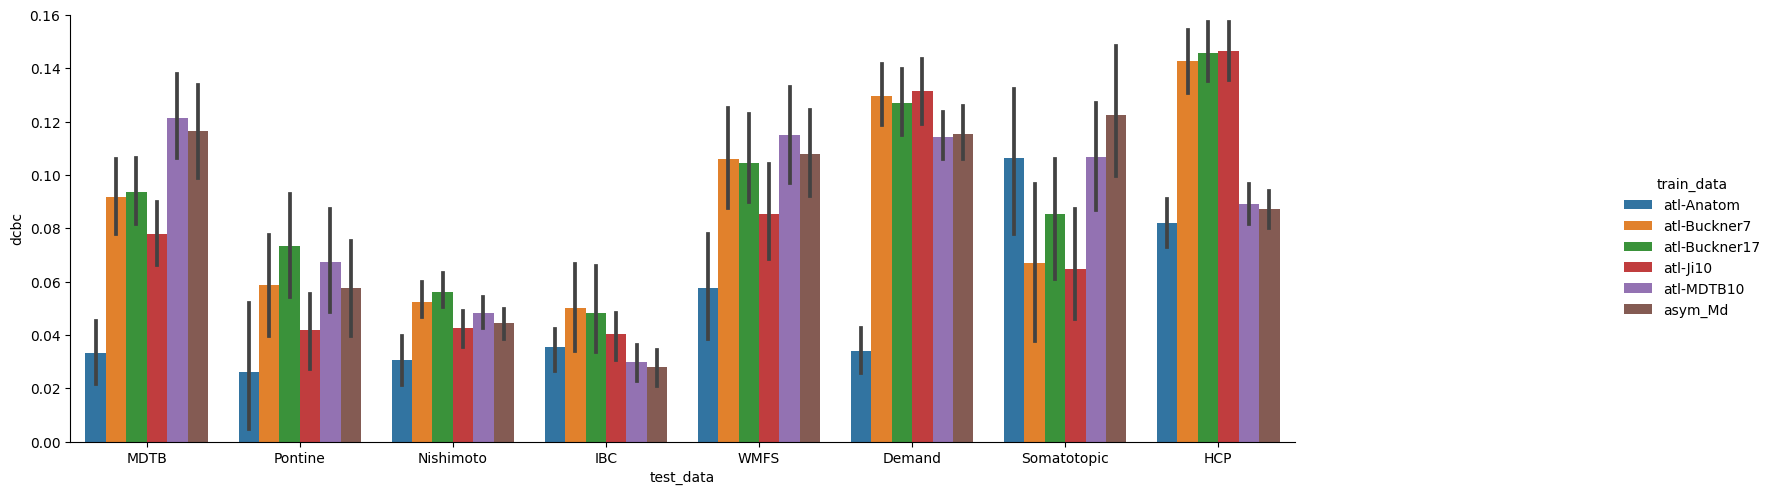

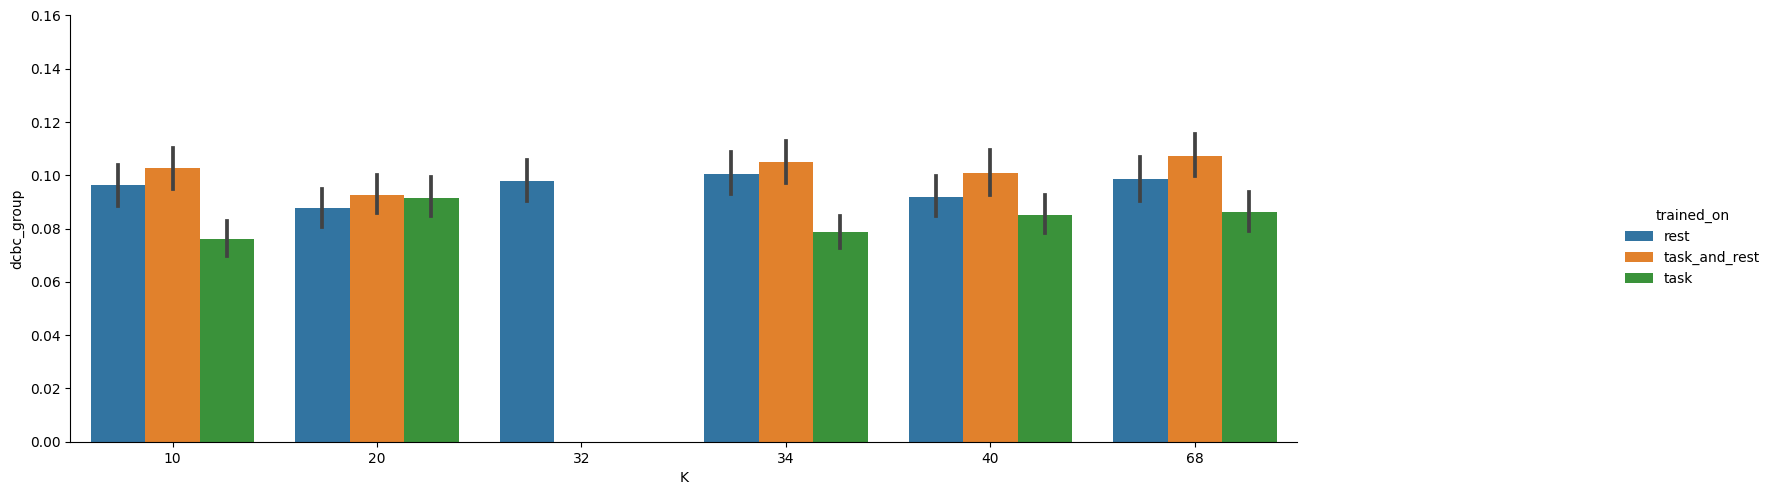

In [10]:



g = sb.catplot(
    data=ex, x="test_data", y="dcbc", hue="train_data", kind="bar", hue_order=['atl-Anatom', 'atl-Buckner7', 'atl-Buckner17', 'atl-Ji10', 'atl-MDTB10', 'asym_Md'])

ex.groupby(['train_data', 'tested_on']).mean()
g.set(ylim=(0, 0.16))
# Make figure wider
g.fig.set_figwidth(20)


K = 68
g = sb.catplot(
    data=D[(D.cv == True)], x="K", y="dcbc_group", hue="trained_on", kind="bar")

g.set(ylim=(0, 0.16))
g.fig.set_figwidth(20)
